In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
scan_name = "Ru_foil_monoscan_001"
DIR = "/das/work/p17/p17983/cropped_data/scan_data/" + scan_name + "/"
DIRBS = "/sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

There are 21 files in the folder /das/work/p17/p17983/cropped_data/scan_data/Ru_foil_monoscan_001/


/sf/alvra/data/p17983/res/scan_info/Ru_foil_monoscan_001_scan_info.json
Processing 21 files
step 1 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0000.BSREAD.h5
images_roi2
<KeysViewHDF5 ['coords_roi1', 'coords_roi2', 'coords_roi3', 'coords_roi4', 'images_roi1', 'images_roi2', 'images_roi3', 'images_roi4', 'pulse_ids']>
/das/work/p17/p17983/cropped_data/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0000.JF02T09V02crop.h5
/sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0000.BSREAD.h5
number of frames
1000
number of surviving frames
409
XES size
(512, 300)
step 2 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0001.BSREAD.h5
images_roi2
<KeysViewHDF5 ['coords_roi1', 'coords_roi2', 'coords_roi3', 'coords_roi4', 'images_roi1', 'images_roi2', 'images_roi3', 'images_roi4', 'pulse_ids']>
/das/work/p17/p17983/cropped_data/scan_data/Ru_foil_monos

<IPython.core.display.Javascript object>


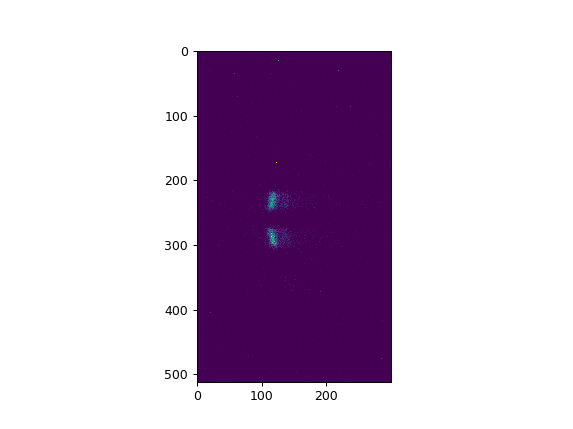

step 12 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0011.BSREAD.h5
images_roi2
<KeysViewHDF5 ['coords_roi1', 'coords_roi2', 'coords_roi3', 'coords_roi4', 'images_roi1', 'images_roi2', 'images_roi3', 'images_roi4', 'pulse_ids']>
/das/work/p17/p17983/cropped_data/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0011.JF02T09V02crop.h5
/sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0011.BSREAD.h5
number of frames
1000
number of surviving frames
404
XES size
(512, 300)
step 13 of 21 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0012.BSREAD.h5
images_roi2
<KeysViewHDF5 ['coords_roi1', 'coords_roi2', 'coords_roi3', 'coords_roi4', 'images_roi1', 'images_roi2', 'images_roi3', 'images_roi4', 'pulse_ids']>
/das/work/p17/p17983/cropped_data/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0012.JF02T09V02crop.h5
/sf/alvra/data/p17983/raw/scan_dat

In [4]:
numstds = 2
minIzero = 0.002
image_threshold = 1.5
hot_pixel = 7.5

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 13

print ("Processing",numFiles,"files")

Energy_eV = np.empty(0)

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    filename = os.path.basename(filename)
    exists = os.path.isfile(DIR + filename.replace("BSREAD","JF02T09V02crop"))
    if not exists:
        print("No such file")
    elif exists and i!=39: #Do we need this 39?
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))

    images, _ = load_JF_cropped_data(DIR + filename.replace("BSREAD","JF02T09V02crop") , 2, nshots=None)
    
    print(DIR + filename.replace("BSREAD","JF02T09V02crop"))
    print(DIRBS + filename)
    
    (_, _, IzeroFEL, _, _, _, Energy, _, _, _ )\
        = load_PumpProbe_events_withTwoVariables(DIRBS + filename, channel_BS_pulse_ids, channel_energy)
    
    total = 0

    IzeroMedian = np.median(IzeroFEL)
    IzeroSTD = np.std(IzeroFEL)
    
    nframes = images.shape[0]

    Energy = [x for x in Energy if (np.abs(x) > 0)]
    Energy_eV = np.append(Energy_eV, np.mean(Energy))

    IzeroMedian = np.median(IzeroFEL)
    IzeroSTD = np.std(IzeroFEL)

    print('number of frames')
    print(nframes)

    images_good = images

    images_thr = images_good.copy()
    images_thr[images_good < image_threshold] = 0
    images_thr[images_good > hot_pixel] = 0
    
    conditionMax = IzeroFEL < IzeroMedian+numstds*IzeroSTD
    conditionMin = IzeroFEL > IzeroMedian-numstds*IzeroSTD
    conditionLow = IzeroFEL > minIzero
    condition = np.logical_and.reduce((conditionLow, conditionMin, conditionMax)).T[0]
    
    images_thr = images_thr[condition]

    print('number of surviving frames')
    print(images_thr.shape[0])

    XES = images_thr.sum(axis=0)/images_thr.shape[0]
    
    print("XES size")
    print(XES.shape)
    
    if i == 10:
        
        plt.figure()
        plt.imshow(XES, vmax = 0.1, vmin = 0)
    
    if i == 0:
        RIXS = XES.sum(axis=0)
    else:
        RIXS = np.vstack((RIXS,XES.sum(axis=0)))

print("RIXS shape")
print(RIXS.shape)


<IPython.core.display.Javascript object>


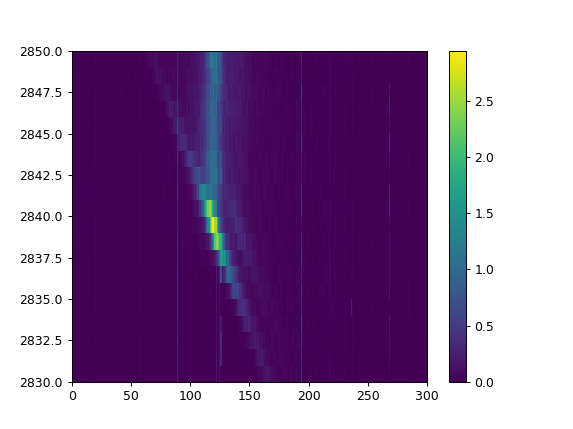

In [5]:
np.linspace(0,RIXS.shape[1],RIXS.shape[1]+1)

X,Y = np.meshgrid(np.linspace(0,RIXS.shape[1],RIXS.shape[1]+1),Energy_eV)
plt.figure()
plt.pcolor(X,Y,RIXS)
plt.colorbar()

<IPython.core.display.Javascript object>


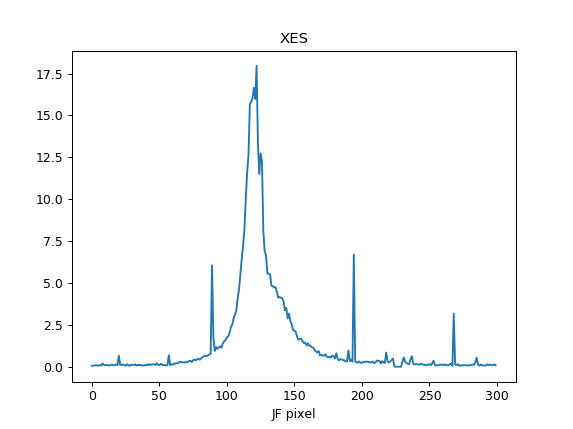

Text(0.5, 1.0, 'XES')

In [6]:
plt.figure()
plt.plot(sum(RIXS))
plt.xlabel('JF pixel')
plt.title('XES')

<IPython.core.display.Javascript object>


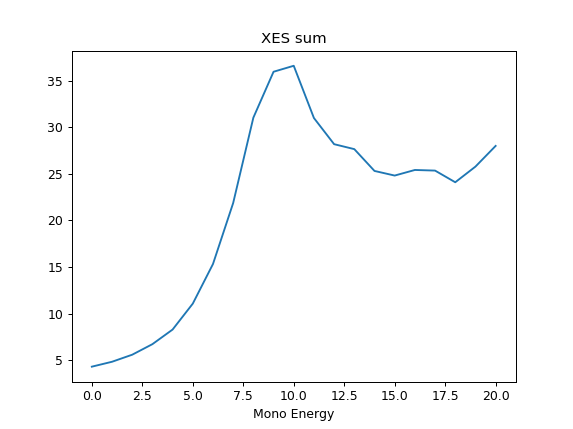

Text(0.5, 1.0, 'XES sum')

In [7]:
plt.figure()
plt.plot(RIXS.sum(axis=1))
plt.xlabel('Mono Energy')
plt.title('XES sum')